In [1]:
%load_ext autoreload
%autoreload 2

## Initialisation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from LogGabor import LogGabor
import torch
from torchvision import datasets, transforms
import os
import noise
import MotionClouds as mc

In [3]:
from Where import *

Loading accuracy... min, max= 0.0145 0.9852


In [8]:

def randomized_perlin_noise(shape=(128,128), scale=10, octaves=6, persistence=0.5, lacunarity=2.0, base=0):
    noise_vector = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise_vector[i][j] = noise.pnoise2(i/scale,
                                        j/scale,
                                        octaves=int(octaves * abs(np.random.randn()))+1,
                                        persistence=persistence * abs(np.random.randn()),
                                        lacunarity=lacunarity * abs(np.random.randn()),
                                        repeatx=shape[0], 
                                        repeaty=shape[1], 
                                        base=base)           

    return noise_vector



In [4]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=False,    #def the dataset as training data 
                   download=True,  #download if dataset not present on disk
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
                   batch_size=1, 
                   shuffle=True)

# LogPolar filter parameters
N_theta, N_orient, N_scale, N_phase = 6, 12, 5, 2
rho = 1.61803 
N_X, N_Y = 128, 128

phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y, rho)
phi_vector = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
phi_plus = np.linalg.pinv(phi_vector)

i_offset, j_offset = 15, 15

### MNIST_28

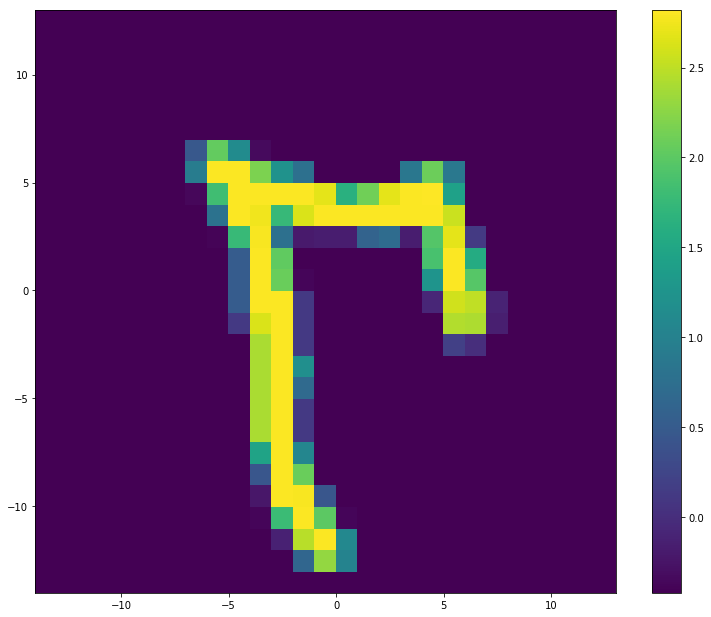

In [5]:
path = 'MNIST_28.pdf'
N_pic = 28
for batch_idx, (data, target) in enumerate(data_loader):
    data_28 = data[-1][-1]
    fig, ax = plt.subplots(figsize=(13, 10.725))
    cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), np.flipud(np.fliplr(data_28)))
    fig.colorbar(cmap)
    plt.savefig(path)
    break

### MNIST_128

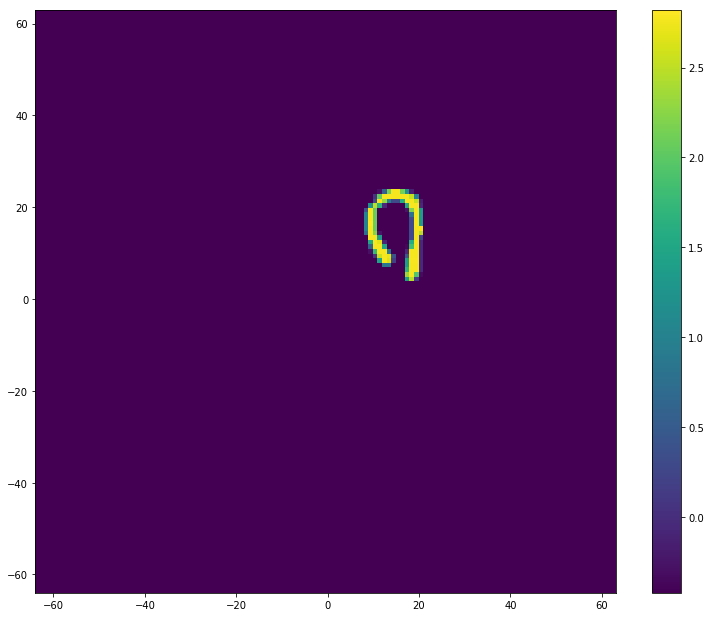

In [6]:
path = 'MNIST_128.pdf'
N_pic = 128
center = (128-28)//2

for batch_idx, (data, target) in enumerate(data_loader):
    data_128 = np.float(data.min()) * np.ones((128,128))
    data_128[(center+i_offset):(center+28+i_offset),(center+j_offset):(center+28+j_offset)] = data
    fig, ax = plt.subplots(figsize=(13, 10.725))
    cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), data_128)
    fig.colorbar(cmap)
    plt.savefig(path)
    break

### Bruit perlin

NameError: name 'randomized_perlin_noise' is not defined

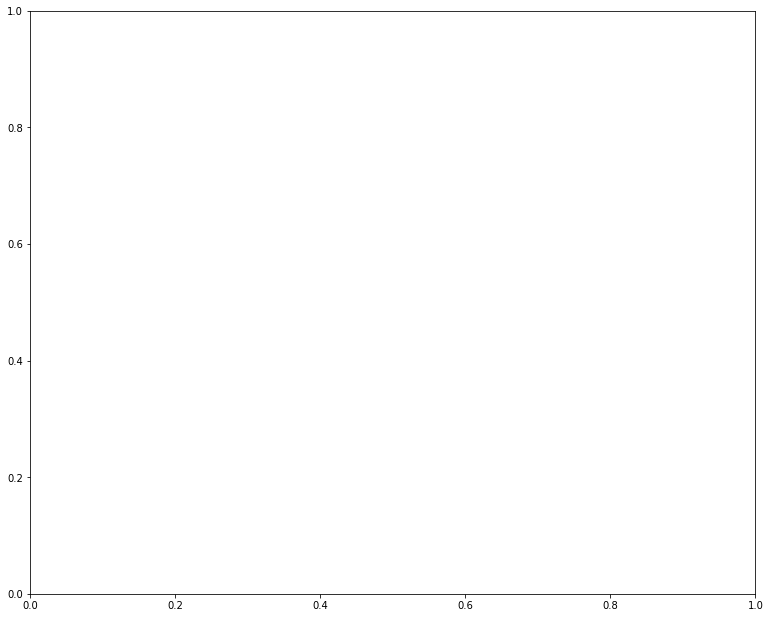

In [7]:
fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), randomized_perlin_noise())
fig.colorbar(cmap)

### Bruit MotionCloud

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), MotionCloudNoise())
fig.colorbar(cmap)

### Filtre LogPol classique

In [11]:
FIG_WIDTH = 10



In [18]:
from Where import *

Loading accuracy... min, max= 0.0145 0.9852


Loading accuracy... min, max= 0.0145 0.9852


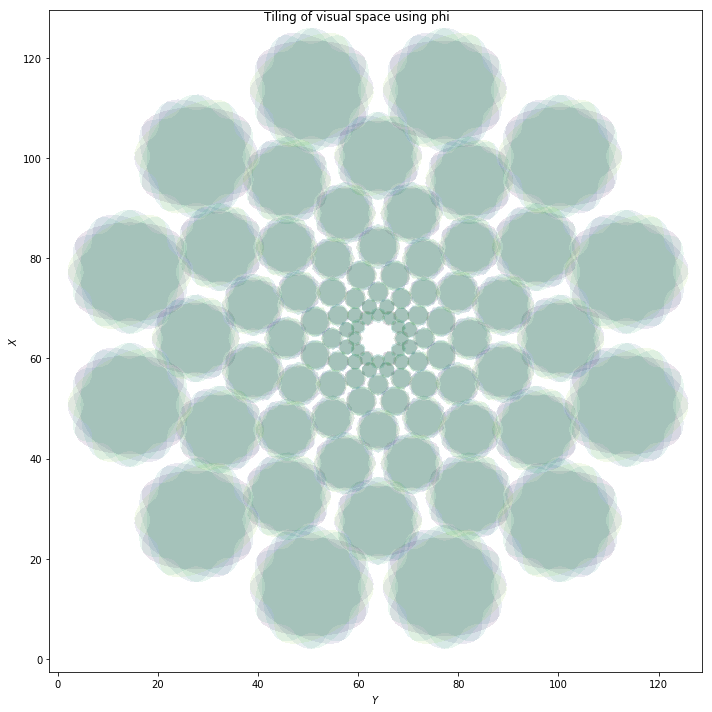

In [26]:
phi = vectorization(N_theta, N_azimuth, N_eccentricty, N_phase, N_X, N_Y, rho)
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_theta in range(N_theta):
    for i_orient in range(N_azimuth):
        for i_scale in range(N_eccentricty):
            env = np.sqrt(phi[i_theta, i_orient, i_scale, 0, :]**2 + phi[i_theta, i_orient, i_scale, 1, :]**2).reshape((N_X, N_Y))
            ax.contourf(env, levels=[env.max()/1.2, env.max()/1.00001], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))], alpha=.1)
fig.suptitle('Tiling of visual space using the retinal filters')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()
plt.savefig('logpol_filter.pdf')

In [20]:
rho

1.41

### Filtre LogPol classique + image

In [ ]:
mnist_fullfield(data_28, i_offset,j_offset, noise=False, figure_type='cmap')
plt.savefig('mnist_128_LP_nonoise.pdf')

### Filtre LogPol classique + image + bruit perlin

In [ ]:
mnist_128(i_offset,j_offset, noise=True, noise_type='Perlin')

### Filtre LogPol classique + image + bruit MotionCloud

In [ ]:
mnist_128(i_offset,j_offset, noise=True, noise_type='MotionCloud')
plt.savefig('mnist_128_LP_MotionCloud.pdf')

### Filtre LogPolaire + image + MotionCloud (méthode alternative de déplacement de MNIST au sein de l'image)

In [ ]:
mnist_128_meth2(i_offset, j_offset)

### Filtre LogPol + orientations moyennées

In [ ]:
energy = (phi**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_orient*N_scale, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_orient):
    for i_scale in range(N_scale):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()
plt.savefig('logpol_energy_filter.pdf')

### Filtre LogPol + orientations moyennées + accuracy

In [ ]:
path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy =  np.load(path)

accuracy_128(i_offset,j_offset)
plt.savefig('accuracy_128_LP.pdf')

### LogPolar view

In [ ]:
mnist_128(i_offset,j_offset, noise=False, figure_type='log')
plt.savefig('mnist_log_nonoise.pdf')

### LogPolar view + noise

In [ ]:
mnist_128(i_offset, j_offset, figure_type='log')
plt.savefig('mnist_log_motioncloud.pdf')